In [1]:
from basic_tools import *
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

In [2]:
h2_total=pd.read_csv(h2_total_par_filtered_path,index_col='phenotype')
h2_total.shape

(497, 7622)

# Parsing result of partitioned LDSC

In [3]:
suffix_bp_list_power="bp300 bp128 bp64 bp32 bp16 bp8".split()

In [4]:
regression_result_bp_list_dict=dict([make_regression_result_list(h2_total,phenotype,suffix_bp_list_power) for phenotype in phenotypes_par_filtered.index])

In [5]:
def calculate_per_bp_var(regression_result_list_dict,suffix_list,mode='default'):
    var_list=[]
    for idx,value in enumerate(suffix_list):
        h2_df=pd.DataFrame([[phenotype]+((regression_result_list[idx]['h2']/regression_result_list[idx]['h2'].sum())/regression_result_list[idx]['category'].apply(category_to_format,args=('bp_range',))).tolist() for phenotype,regression_result_list in regression_result_list_dict.items()])
        #h2_df=pd.DataFrame([[phenotype]+((regression_result_list[idx]['h2']/regression_result_list[idx]['h2'].sum())/1).tolist() for phenotype,regression_result_list in regression_result_list_dict.items()])
        h2_df=h2_df.set_index(0)

        if mode=='default':
            values=h2_df.var(axis=1)
        elif mode=='mono':
            h2_mono=pd.Series(0.0,index=np.arange(h2_df.shape[1]));h2_mono[0]=1/category_to_format(list(regression_result_bp_list_dict.values())[0][idx]['category'].loc[0],'bp_range',)
            values=h2_df.var(axis=1)/h2_mono.var()
        elif mode=='max_and_poly':
            h2_mono=pd.Series(0.0,index=np.arange(h2_df.shape[1]));h2_mono[0]=1/category_to_format(list(regression_result_bp_list_dict.values())[0][idx]['category'].loc[0],'bp_range',)
            h2_poly=pd.Series(1.0,index=np.arange(h2_df.shape[1]));h2_poly=h2_poly/list(regression_result_bp_list_dict.values())[0][idx]['category'].apply(category_to_format,args=('bp_range',)).sum()
            #var_list.append(1-(h2_df.var(axis=1)-h2_poly.var())/(h2_df.var(axis=1).max()-h2_poly.var()))#-h2_df.mean(axis=1))
            values=(h2_df.var(axis=1)-0)/(h2_df.var(axis=1).max()-0)
        elif mode=='test':
            values=-np.log10(h2_df.var(axis=1))
            8.580318	
            values=(values.max()-values)
            values=1-values/values.max()
            #values=values-values.min()
            #values=1-(values-values.min())/(values.max()-values.min())
        else:
            raise
        var_list.append(values)
    var_df=pd.DataFrame(var_list,index=suffix_list)
    return var_df.T
per_bp_var=calculate_per_bp_var(regression_result_bp_list_dict,suffix_bp_list_power,mode='test')
#per_bp_var.sort_values('bp8',ascending=False)

found that variables 'gwas_result_sample','chr_bp_max' were not loaded. trying to load the variables
gwas_result_sample.shape: (13364303, 18)


In [6]:
def anova_regression_result_times(regression_result,times):
    h2_upscale=pd.DataFrame([(regression_result['h2']/regression_result['h2'].sum())/regression_result['category'].apply(category_to_format,args=('bp_range',)).values,regression_result['category'].apply(category_to_format,args=(times,))]).T    
    h2_upscale_grouped=(h2_upscale.groupby('category')['h2'].apply(list))
    f_statistic,f_statistic_pval=st.f_oneway(*h2_upscale_grouped.values)    
    #print(h2_upscale_grouped)
    return f_statistic,f_statistic_pval

In [7]:
regression_result_bp_list_dict['23115_irnt'][5].shape

(358, 7)

In [8]:
anova_list_list_times=[[phenotype]+list(map(lambda x: anova_regression_result_times(regression_result_list[-1],x),list(range(len(suffix_bp_list_power)-1,0,-1)))) for phenotype,regression_result_list in regression_result_bp_list_dict.items()]

In [9]:
anova_df_f_times=pd.DataFrame([[anova_list[0]]+[anova[0] for anova in anova_list[1:]] for idx,anova_list in enumerate(anova_list_list_times)])
anova_df_f_times=anova_df_f_times.set_index(0)
anova_df_f_times.columns=suffix_bp_list_power[:-1]
anova_df_f_times.head()

anova_df_pval_times=pd.DataFrame([[anova_list[0]]+[anova[1] for anova in anova_list[1:]] for idx,anova_list in enumerate(anova_list_list_times)])
anova_df_pval_times=anova_df_pval_times.set_index(0)
anova_df_pval_times.columns=suffix_bp_list_power[:-1]
anova_df_pval_times.head()

,bp300,bp128,bp64,bp32,bp16
0,,,,,
50_irnt,0.011109,0.003130,0.000012,0.000023,1.009341e-03
20153_irnt,0.013600,0.008790,0.000252,0.000203,8.324001e-04
5097_irnt,0.000013,0.000660,0.037244,0.000137,1.898413e-33
5098_irnt,0.000051,0.001458,0.038098,0.000048,7.970358e-29
30100_irnt,0.098872,0.093447,0.110663,0.292819,1.182984e-04


In [10]:
plt.rcParams['font.family']='Arial'

In [18]:
plt.rcParams["figure.figsize"] = (80,5)
plt.rcParams["font.size"] = 30


anova_plot_data=anova_df_pval_times.copy()
anova_plot_data.columns=anova_plot_data.columns.str.replace('bp','')+'Mb'
anova_plot_data.columns=anova_plot_data.columns.str.replace('300Mb','Chr')
#anova_plot_data=-np.log10(anova_plot_data.loc[per_bp_var['bp8'].sort_values(ascending=False).index].iloc[:50,:].T)#,cmap=plt.cm.rainbow)
#
anova_plot_data=-np.log10(anova_plot_data.loc[per_bp_var['bp8'].sort_values(ascending=False).index].T)#,cmap=plt.cm.rainbow)

#.loc[index_select]



In [19]:
len_group=5
index_select=[value for idx,value in enumerate(anova_plot_data.columns) if idx%50<len_group]

In [20]:
anova_plot_data[index_select].columns.map(code_to_description).map(lambda x: description_to_short(x,'abbr_pub_ori',"anova"))

Index(['Degree: university', 'Leg fat percentage', 'Arm fat percentage', 'BMI',
       'Age first had sexual intercourse', 'Neuroticism score',
       'Creatinine (enzymatic) in urine', 'FVC', 'Tense / 'highly strung'',
       'Mood swings', 'Smoking status: Previous',
       'Diseases of the musculoskeletal system and connective tissue',
       'Diseases of the digestive system',
       'Qualifications: O levels/GCSEs or equivalent',
       'Frequency of depressed mood in last 2 weeks', 'Neck or shoulder pain',
       'Heel bone mineral density (BMD) (left)',
       'Other serious medical condition/disability diagnosed by doctor',
       'Qualifications: Other professional qualifications eg: nursing, teaching',
       'Age started wearing glasses or contact lenses',
       'Physically abused by family as a child', 'Supplements: Fish oil',
       'Supplements: others', 'Financial situation satisfaction',
       'Eosinophill percentage', 'Monocyte count',
       'Number of fluid intelli

In [46]:
anova_plot_data[index_select[3*len_group:(3+1)*len_group]].columns.map(code_to_description)

Index(['Pain type(s) experienced in last month: Neck or shoulder pain',
       'Heel bone mineral density (BMD) (left)',
       'Other serious medical condition/disability diagnosed by doctor',
       'Qualifications: Other professional qualifications eg: nursing, teaching',
       'Age started wearing glasses or contact lenses'],
      dtype='object', name=0)

In [ ]:
description_dict_merge=pd.read_csv(description_dict_merge_path,sep='\t',index_col='description')
def description_to_short(desc,mode='pub',suffix="basic"):

    description_dict=description_dict_merge
    
    
    if not mode in ['ori','pub','abbr','abbr_pub','abbr_pub_ori']:
        raise    
    if desc in description_dict.index:
        if mode=='ori':
            return desc
        elif mode=='pub':
            #print(correlation_description_dict['description_pub'].loc['Tobacco smoking: Ex-smoker'],description_dict['description_pub'].loc['Tobacco smoking: Ex-smoker'])
            return description_dict['description_pub'+"_"+suffix].loc[desc]
        elif mode=='abbr':
            return description_dict['description_abbr'+"_"+suffix].loc[desc]
        elif mode=='abbr_pub':
            abbr=description_to_short(desc,mode='abbr',suffix=suffix)
            return description_to_short(desc,mode='pub',suffix=suffix) if type(abbr)==float or abbr=='' else abbr
        elif mode=='abbr_pub_ori':
            abbr_pub=description_to_short(desc,mode='abbr_pub',suffix=suffix)
            #print(abbr_pub)
            return desc if type(abbr_pub)==float or abbr_pub=='' else abbr_pub
    else:
        return np.nan

0
1
2
3
4
5
6
7
8
9


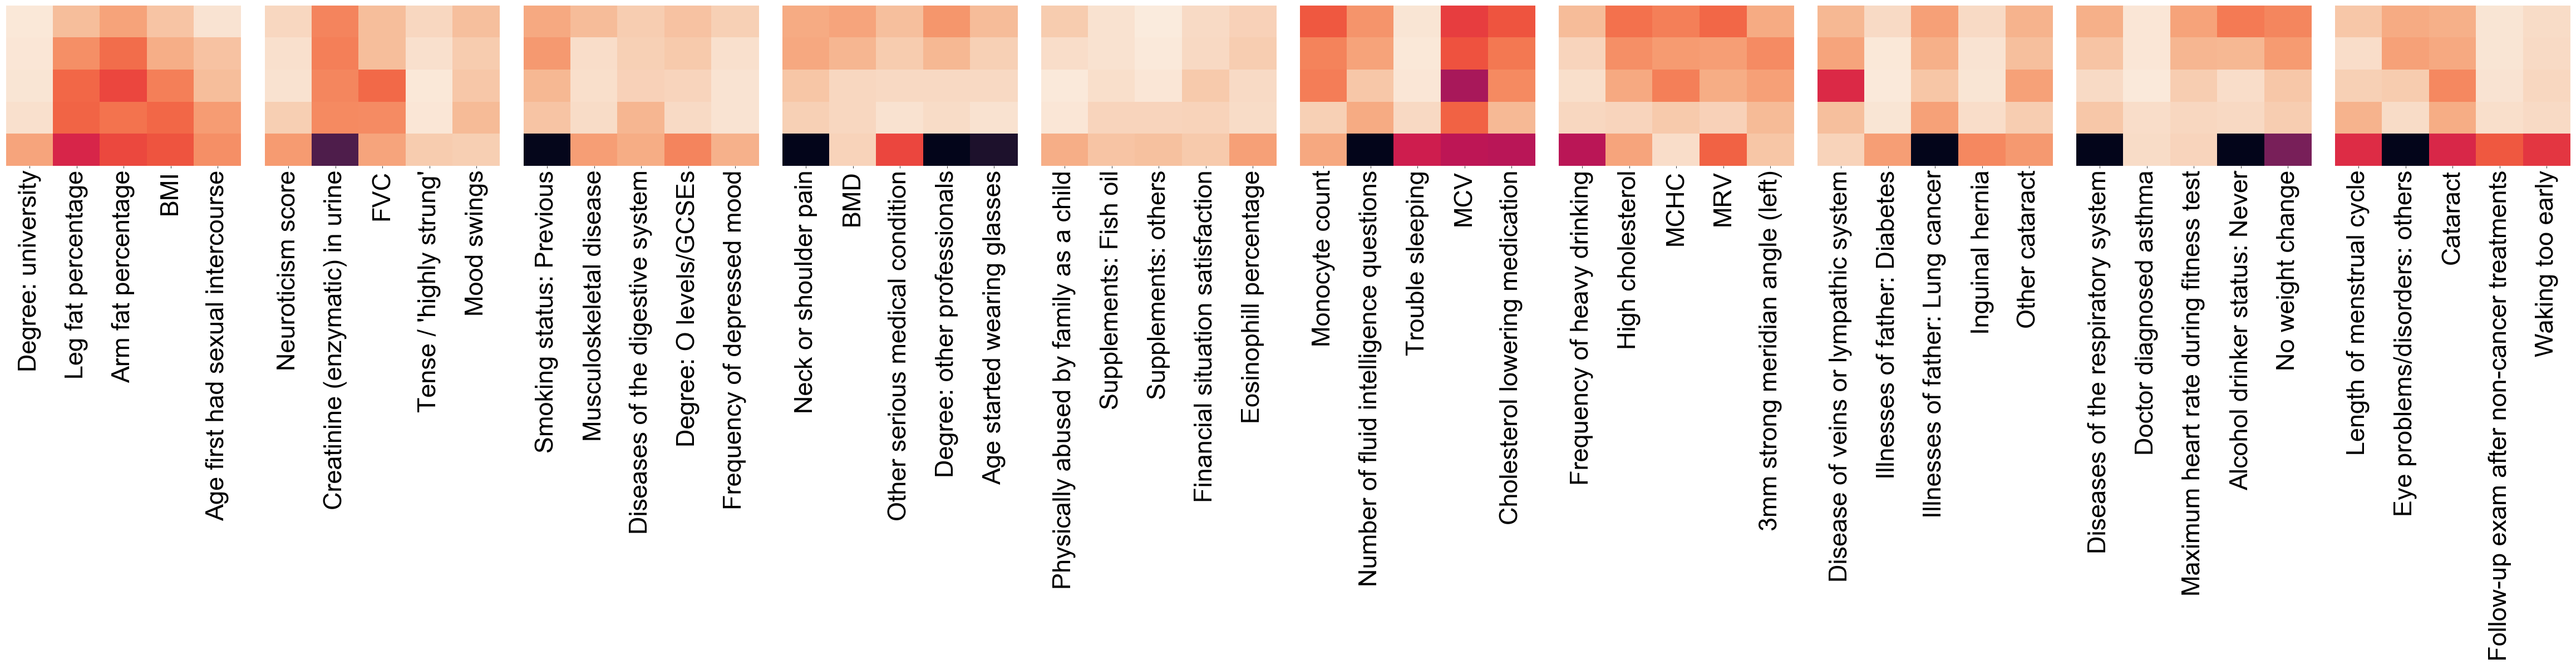

In [64]:
plt.rcParams["figure.figsize"] = (80,5)
plt.rcParams["font.size"] = 45

fig, axes =plt.subplots(ncols=len(index_select)//len_group)

left = 0.07; right=0.87
bottom = 0.1; top = 0.9
#fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(figw, figh), gridspec_kw=gridspec_kw)
asp=0.5

plt.subplots_adjust(left=left, right=right, bottom=bottom, top=top, wspace=0.1, hspace=0.1*asp )

for i in range(0,len(index_select)//len_group):
    print(i)
    plot_data=anova_plot_data[index_select[i*len_group:(i+1)*len_group]]
    plot_data.columns=plot_data.columns.map(code_to_description).map(lambda x: description_to_short(x,'abbr_pub_ori',"anova"))
    
    sns.heatmap(plot_data, ax=axes[i], yticklabels=False,cbar=False,cmap=sns.cm.rocket_r,vmin=0,vmax=10)
    #axes[i].set_ylabel('')    
    axes[i].set_xlabel('')
plt.savefig('anovafig.png',bbox_inches="tight")

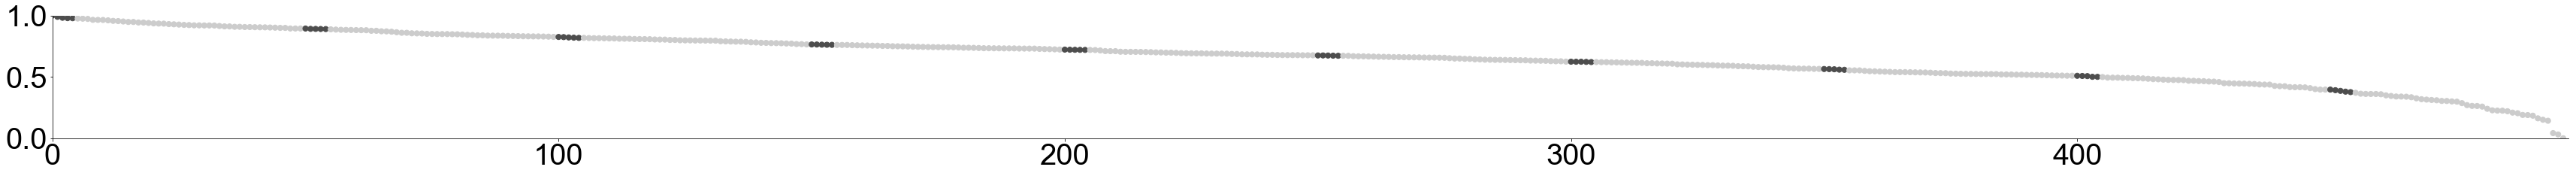

In [61]:
plt.rcParams["figure.figsize"] = (60,3)
plt.rcParams["font.size"] = 40

plt.scatter(list(range(0,len(per_bp_var['bp8'][anova_plot_data.columns]))),per_bp_var['bp8'][anova_plot_data.columns],color=[(0.3,0.3,0.3,1) if col in index_select else (0.8,0.8,0.8,1) for col in anova_plot_data.columns],s=50)

plt.xlim(0,len(anova_plot_data.columns))
plt.ylim(0,1)
#plt.yticks([], [])

sns.despine()
plt.savefig('savefig_polygenicity.png',bbox_inches="tight")

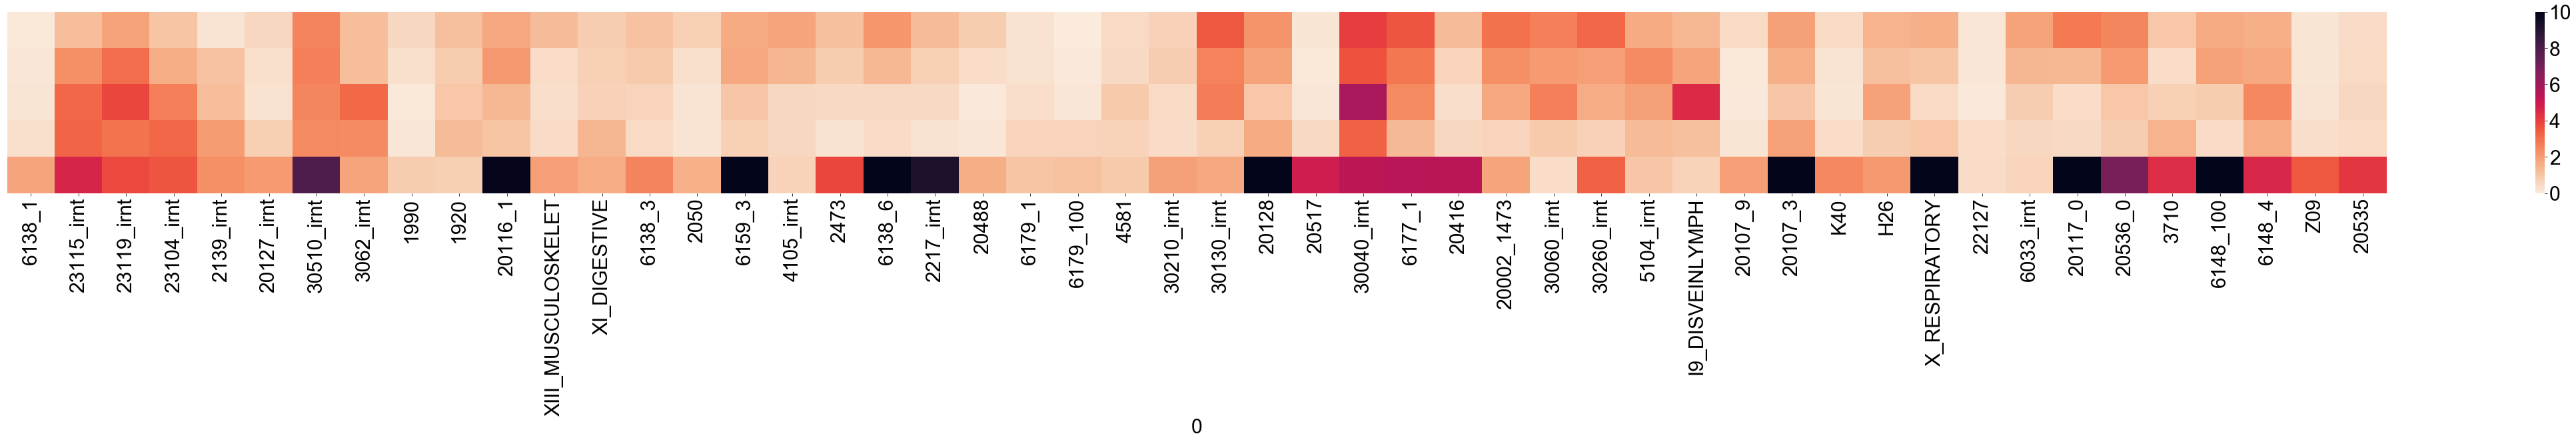

In [15]:
sns.heatmap(anova_plot_data[index_select], yticklabels=False,cbar=True,cmap=sns.cm.rocket_r,vmin=0,vmax=10)
#plt.xticks([])